## Lab: Non-Linear Modeling
Reference: James, G., Witten, D., Hastie, T., Tibshirani, R.,, Taylor, J. (2023). An Introduction to Statistical Learning with Applications in Python. Cham: Springer. ISBN: 978-3-031-38746-3

In [1]:
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (summarize, poly, ModelSpec as MS)
from statsmodels.stats.anova import anova_lm

In [2]:
from pygam import (s as s_gam, l as l_gam, f as f_gam, LinearGAM, LogisticGAM)
from ISLP.transforms import (BSpline, NaturalSpline)
from ISLP.models import bs, ns
from ISLP.pygam import (approx_lam, degrees_of_freedom, plot as plot_gam, anova as anova_gam)

We use the `Wage` data as a running example, and show tha many of the complex non-linear fitting procedures. Throughout most of this lab, our response is `Wage['wage']`, which we have stored as y above. We will use the `poly()` function to create a model matrix that will fit a `4th` degree polynomial in age.

####  Polynomial Regression and Step Functions

In [3]:
Wage = load_data('Wage')
y = Wage['wage']
age = Wage['age']

 Here `poly()` is referred to as a helper function, and sets up the transformation; Poly() is the actual workhorse that computes the transformation.

In [4]:
poly_age = MS([poly('age', degree=5)]).fit(Wage)
M = sm.OLS(y, poly_age.transform(Wage)).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,111.7036,0.729,153.278,0.000
"poly(age, degree=5)[0]",447.0679,39.916,11.200,0.000
"poly(age, degree=5)[1]",-478.3158,39.916,-11.983,0.000
"poly(age, degree=5)[2]",125.5217,39.916,3.145,0.002
"poly(age, degree=5)[3]",-77.9112,39.916,-1.952,0.051
"poly(age, degree=5)[4]",-35.8129,39.916,-0.897,0.370


In [5]:
age_grid = np.linspace(age.min(), age.max(), 100)
age_df = pd.DataFrame({'age' : age_grid})

In [6]:
def  plot_wage_fit(age_df, basis, title):
    X       = basis.transform(Wage)
    Xnew    = basis.transform(age_df)
    M       = sm.OLS(y, X).fit()
    preds   = M.get_prediction(Xnew)
    bands   = preds.conf_int(alpha=0.05)
    fig, ax = subplots(figsize=(8,8))
    ax.scatter(age, y, facecolor='gray',alpha=0.5)
    
    for val, ls in zip([preds.predicted_mean,
                        bands[:,0],
                        bands[:,1]],
                        ['b','r--','r--']):
        ax.plot(age_df.values, val, ls, linewidth=3)
    ax.set_title(title, fontsize=10)
    ax.set_xlabel('Age', fontsize=10)
    ax.set_ylabel('Wage', fontsize=10)
    return ax

<Axes: title={'center': 'Degree-4 Polynomial'}, xlabel='Age', ylabel='Wage'>

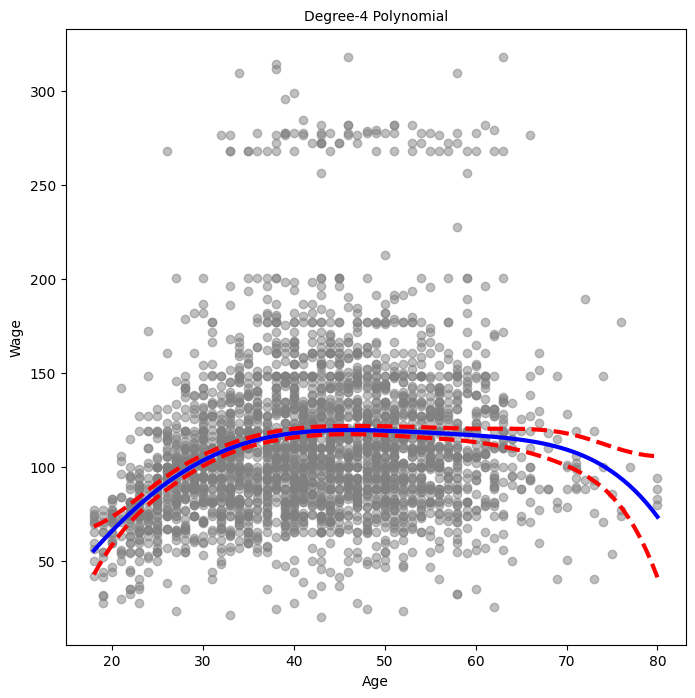

In [7]:
plot_wage_fit(age_df, poly_age, 'Degree-4 Polynomial')

Polynomial regression requires deciding on the degree of the polynomial to use. While it's common to guess and use second- or third-degree polynomials for a nonlinear fit, a more systematic approach involves hypothesis testing. Here, we demonstrate this process by fitting a series of models ranging from linear (degree-one) to degree-five polynomials. The goal is to identify the simplest model sufficient to explain the relationship between wage and age.

We use the `anova_lm()` function to perform a series of ANOVA (Analysis of Variance) tests. These tests evaluate the null hypothesis that a simpler model $M_1$ adequately explains the data against the alternative hypothesis that a more complex model $M_2$ is necessary. The decision is based on an F-test, which requires the models $ M_1$ and $M_2$ to be nested—that is, the predictors in $M_1$ must form a subset of those in $M_2$.

In this example, we fit five polynomial models and compare each simpler model sequentially with its more complex counterpart to determine the appropriate complexity for the regression.

In [8]:
models  = [MS([poly('age', degree=d)]) for d in range(1, 6)]
Xs      = [model.fit_transform(Wage) for model in models]
anova_lm(*[sm.OLS(y , X_).fit() for X_ in Xs]) 

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.593107,2.363850e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.888756,1.679202e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.809813,5.104620e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.804976,3.696820e-01


In [9]:
summarize(M)

,coef,std err,t,P>|t|
intercept,111.7036,0.729,153.278,0.000
"poly(age, degree=5)[0]",447.0679,39.916,11.200,0.000
"poly(age, degree=5)[1]",-478.3158,39.916,-11.983,0.000
"poly(age, degree=5)[2]",125.5217,39.916,3.145,0.002
"poly(age, degree=5)[3]",-77.9112,39.916,-1.952,0.051
"poly(age, degree=5)[4]",-35.8129,39.916,-0.897,0.370


Indexing starting at zero is confusing for the polynomial degree example, since `models[1]` is quadratic rather than linear. Hence, either a cubic or a quartic polynomial, `models[2]` and `models[3]` respectively, appears to provide a reasonable fit to the data, while lower- or higher-order models are not justified.

Notice that the p-values are identical, and indeed the square of the t-statistics matches the F-statistics from the `anova_lm()` function. For example:

In [10]:
(-11.983)**2

143.59228900000002

However, the ANOVA method works regardless of whether we use orthogonal polynomials, as long as the models are nested. For example, we can use `anova_lm()` to compare the following three models, each containing a linear term for `education` and a polynomial term for `age` of varying degrees:

In [11]:
models = [MS(['education', poly('age', degree=d)])
for d in range(1, 4)]
XEs = [model.fit_transform(Wage)
for model in models]
anova_lm(*[sm.OLS(y, X_).fit() for X_ in XEs])

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2997.0,3.902335e+06,0.0,NaN,NaN,NaN
1,2996.0,3.759472e+06,1.0,142862.701185,113.991883,3.838075e-26
2,2995.0,3.753546e+06,1.0,5926.207070,4.728593,2.974318e-02


As an alternative to using hypothesis tests and ANOVA, we could choose the polynomial degree using cross-validation.

Next we consider the task of predicting whether an individual earns more
 than $250,000 per year. We proceed much as before, except that first we
 create the appropriate response vector, and then apply the `glm()` function
 using the binomial family in order to fit a polynomial logistic regression
 model.

In [12]:
X = poly_age.transform(Wage)
high_earn = Wage['high_earn'] = y > 250
glm = sm.GLM(y > 250, X, family=sm.families.Binomial())
B = glm.fit()
summarize(B)  

,coef,std err,z,P>|z|
intercept,-4.1039,0.243,-16.877,0.000
"poly(age, degree=5)[0]",25.4507,24.945,1.020,0.308
"poly(age, degree=5)[1]",-79.9414,32.483,-2.461,0.014
"poly(age, degree=5)[2]",-40.5919,43.871,-0.925,0.355
"poly(age, degree=5)[3]",-50.0105,26.491,-1.888,0.059
"poly(age, degree=5)[4]",-42.9586,24.803,-1.732,0.083


Once again, we make predictions using the `get_prediction()` method.

In [13]:
newX = poly_age.transform(age_df)
preds = B.get_prediction(newX)
bands = preds.conf_int(alpha=0.05)

Text(0, 0.5, 'P(Wage > 250)')

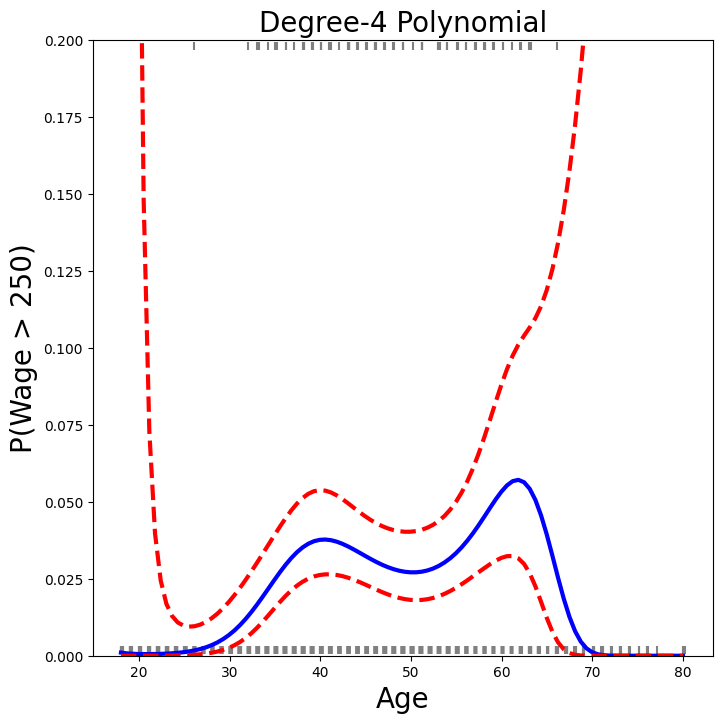

In [14]:
fig, ax = subplots(figsize=(8,8))
rng = np.random.default_rng(0)
ax.scatter( age +
            0.2 * rng.uniform(size=y.shape[0]),
            np.where(high_earn, 0.198, 0.002),
            fc='gray',
            marker='|')
for val, ls in zip([preds.predicted_mean,
                    bands[:,0],
                    bands[:,1]],
                    ['b','r--','r--']):
    ax.plot(age_df.values, val, ls, linewidth=3)
ax.set_title('Degree-4 Polynomial', fontsize=20)
ax.set_xlabel('Age', fontsize=20)
ax.set_ylim([0,0.2])
ax.set_ylabel('P(Wage > 250)', fontsize=20)

We have displayed the age values for observations with wage values above 250 as gray marks at the top of the plot, while those with wage values below 250 are shown as gray marks at the bottom. To avoid overlapping, a small amount of noise was added to jitter the age values slightly. This visualization technique is commonly referred to as a rug plot.

In order to fit a step function, we first use the `pd.qcut()` function to discretize `age` based on quantiles. Then we use `pd.get_dummies()` to create the columns of the model matrix for this categorical variable. Note that this function will include all columns for a given categorical, rather than the usual approach which drops one of the levels.

In [15]:
cut_age = pd.qcut(age, 4)
summarize(sm.OLS(y, pd.get_dummies(cut_age)).fit())

,coef,std err,t,P>|t|
"(17.999, 33.75]",94.1584,1.478,63.692,0.0
"(33.75, 42.0]",116.6608,1.470,79.385,0.0
"(42.0, 51.0]",119.1887,1.416,84.147,0.0
"(51.0, 80.0]",116.5717,1.559,74.751,0.0


The `pd.qcut()` function automatically determines cut points based on quantiles—in this case, the 25%, 50%, and 75% quantiles—resulting in four regions. Alternatively, we could have specified custom quantiles directly instead of using the argument `4`. For cuts not based on quantiles, the `pd.cut()` function can be used. Both `pd.qcut()` and `pd.cut()` return an ordered categorical variable. 

In the regression model, these categories are represented by a set of dummy variables. Since age is the only predictor in the model, the value \$94,158.40 represents the average salary for individuals under 33.75 years of age, while the other coefficients represent the average salary for individuals in the other age groups. Predictions and plots can be generated in the same way as with polynomial fits.

####  Splines

We saw that regression splines can be fit by constructing an appropriate matrix of basis functions. The `BSpline()` function generates the entire matrix of basis functions for splines with the specified set of
 knots. By default, the B-splines produced are cubic. To change the degree,
 use the argument degree.

In [16]:
bs_ = BSpline(internal_knots=[25, 40, 60], intercept=True).fit(age)
bs_age = bs_.transform(age)
bs_age.shape

(3000, 7)

This results in a seven-column matrix, which is what is expected for a cubic
spline basis with 3 interior knots.  We now fit a cubic spline model to the `Wage` data.

In [17]:
bs_age = MS([bs('age', internal_knots=[25,40, 60], name='bs(age)')])
Xbs = bs_age.fit_transform(Wage)
M = sm.OLS(y, Xbs).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,60.4937,9.460,6.394,0.000
bs(age)[0],3.9805,12.538,0.317,0.751
bs(age)[1],44.6310,9.626,4.636,0.000
bs(age)[2],62.8388,10.755,5.843,0.000
bs(age)[3],55.9908,10.706,5.230,0.000
bs(age)[4],50.6881,14.402,3.520,0.000
bs(age)[5],16.6061,19.126,0.868,0.385


Notice that there are 6 spline coefficients rather than 7. This is because, by default, `bs()` assumes `intercept=False`, since we typically have an overall
intercept in the model. So it generates the spline basis with the given knots, and then discards one of the basis functions to account for the intercept.

We can also use the `df` (degrees of freedom) option to control the complexity of the spline. For example, with 3 knots, the spline basis has 6 columns or degrees of freedom. If we specify `df=6` instead of explicitly providing the knots, the `bs()` function will automatically create a spline with 3 knots placed at uniform quantiles of the training data. These automatically chosen knots can be examined more clearly by using the `Bspline()` function directly.

In [18]:
BSpline(df=6).fit(age).internal_knots_

array([33.75, 42.  , 51.  ])

When asking for six degrees of freedom, the transform chooses knots at
ages 33.75, 42.0, and 51.0, which correspond to the 25th, 50th, and 75th
percentiles of age.

When using B-splines, we are not restricted to cubic polynomials (i.e., `degree=3`). For example, setting `degree=0` produces piecewise constant functions, similar to the behavior seen in the earlier example with `pd.qcut()`.

In [19]:
bs_age0 = MS([bs('age', df=3, degree=0)]).fit(Wage)
Xbs0 = bs_age0.transform(Wage)
summarize(sm.OLS(y, Xbs0).fit())

,coef,std err,t,P>|t|
intercept,94.1584,1.478,63.687,0.0
"bs(age, df=3, degree=0)[0]",22.3490,2.152,10.388,0.0
"bs(age, df=3, degree=0)[1]",24.8076,2.044,12.137,0.0
"bs(age, df=3, degree=0)[2]",22.7814,2.087,10.917,0.0


Since we specified `df=3` for degree-zero splines, there are knots at the same three quantiles. Although the coefficients appear different, this discrepancy results from the differing coding schemes. For example, the first coefficient is identical in both cases and represents the mean response in the first bin. For the second coefficient, we observe $ 94.158 + 22.349 = 116.507 $, which is close to $ 116.611 $, the mean in the second bin as calculated in cell [15].

In this case, the intercept is coded as a column of ones, while the second, third, and fourth coefficients represent increments for the respective bins. Why aren’t the sums exactly the same? The difference arises because `qcut()` uses <=, whereas `bs()` uses < when deciding bin membership.

In [20]:
cut_age = pd.qcut(age, 4)
summarize(sm.OLS(y, pd.get_dummies(cut_age)).fit())

,coef,std err,t,P>|t|
"(17.999, 33.75]",94.1584,1.478,63.692,0.0
"(33.75, 42.0]",116.6608,1.470,79.385,0.0
"(42.0, 51.0]",119.1887,1.416,84.147,0.0
"(51.0, 80.0]",116.5717,1.559,74.751,0.0


To fit a natural spline, we use the `NaturalSpline()` transformation with the corresponding helper function `ns()`. Here, we fit a natural spline with five degrees of freedom (excluding the intercept) and plot the results.

In [21]:
ns_age = MS([ns('age', df=5)]).fit(Wage)
M_ns = sm.OLS(y, ns_age.transform(Wage)).fit()
summarize(M_ns)

,coef,std err,t,P>|t|
intercept,60.4752,4.708,12.844,0.000
"ns(age, df=5)[0]",61.5267,4.709,13.065,0.000
"ns(age, df=5)[1]",55.6912,5.717,9.741,0.000
"ns(age, df=5)[2]",46.8184,4.948,9.463,0.000
"ns(age, df=5)[3]",83.2036,11.918,6.982,0.000
"ns(age, df=5)[4]",6.8770,9.484,0.725,0.468


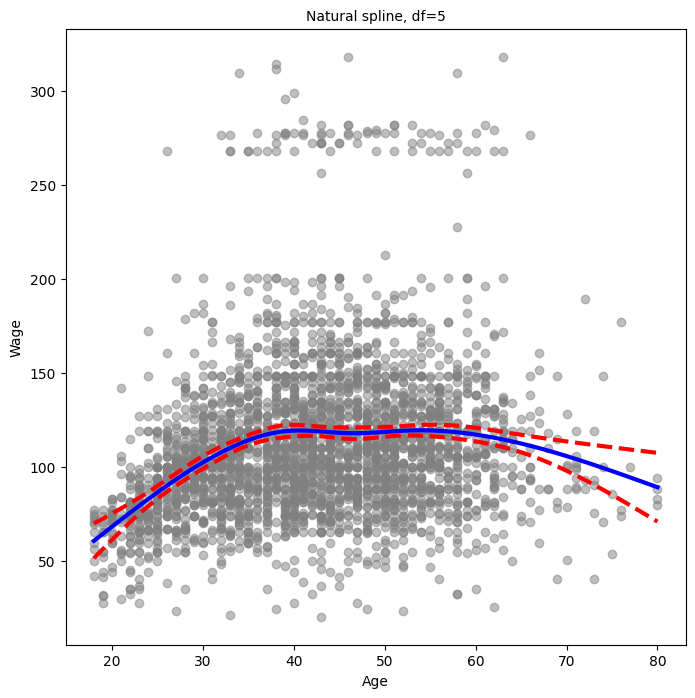

In [22]:
plot_wage_fit(age_df, ns_age, 'Natural spline, df=5');

####  Smoothing Splines and Generalized Additive Models

A smoothing spline is a special case of a Generalized Additive Model (GAM) with squared-error loss and a single feature. The GAM is specified by associating each column of a model matrix with a particular smoothing operation: `sf` for smoothing splines, `l` for linear terms, and `f` for factors or categorical variables. The argument `0` passed to `sbelow` indicates that this smoother will apply to the first column of the feature matrix. In the example below, we pass a matrix with a single column: `X_age`. The argument `lam` represents the penalty parameter $ \lambda $.

In [23]:
X_age = np.asarray(age).reshape((-1,1))
gam = LinearGAM(s_gam(0, lam=0.6))
gam.fit(X_age, y)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + intercept, tol=0.0001, 
   verbose=False)

The pygam library generally expects a matrix of features so we reshape age
 to be a matrix (a two-dimensional array) instead of a vector (i.e. a one
dimensional array). The-1 in the call to the `reshape()` method tells numpy
 to impute the size of that dimension based on the remaining entries of the
 shape tuple.

 The function `np.logspace()` is similar to `np.linspace()`, but it spaces points evenly on a logarithmic scale. In the example below, we vary `lam` from $10^2$ to $10^6$.

<>:11: SyntaxWarning: invalid escape sequence '\l'
<>:11: SyntaxWarning: invalid escape sequence '\l'
C:\Users\miko_\AppData\Local\Temp\ipykernel_16760\3226023619.py:11: SyntaxWarning: invalid escape sequence '\l'
  ax.legend(title='$\lambda$')


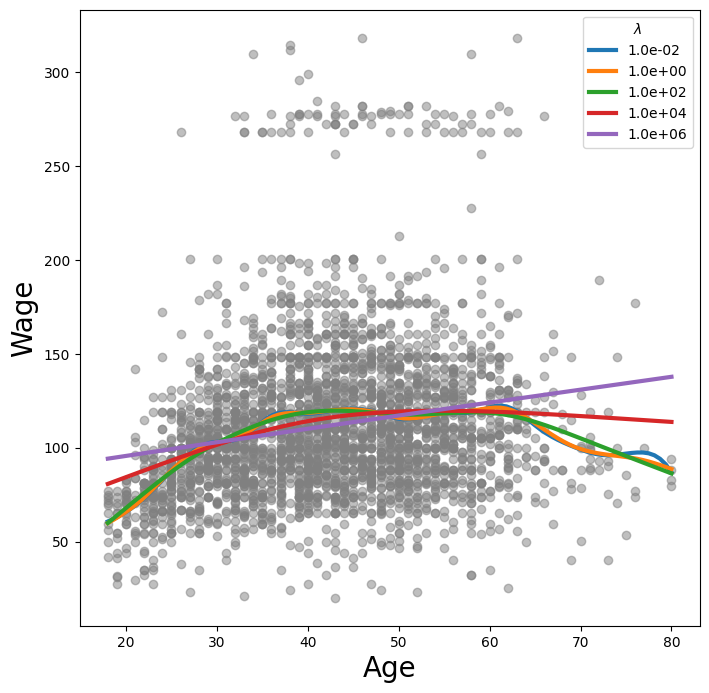

In [24]:
fig, ax = subplots(figsize=(8,8))
ax.scatter(age, y, facecolor='gray', alpha=0.5)
for lam in np.logspace(-2, 6, 5):
    gam = LinearGAM(s_gam(0, lam=lam)).fit(X_age, y)
    ax.plot(age_grid,
            gam.predict(age_grid),
            label='{:.1e}'.format(lam),
            linewidth=3)
ax.set_xlabel('Age', fontsize=20)
ax.set_ylabel('Wage', fontsize=20)
ax.legend(title='$\lambda$')

The pygam package can perform a search for an optimal smoothing parameter.

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


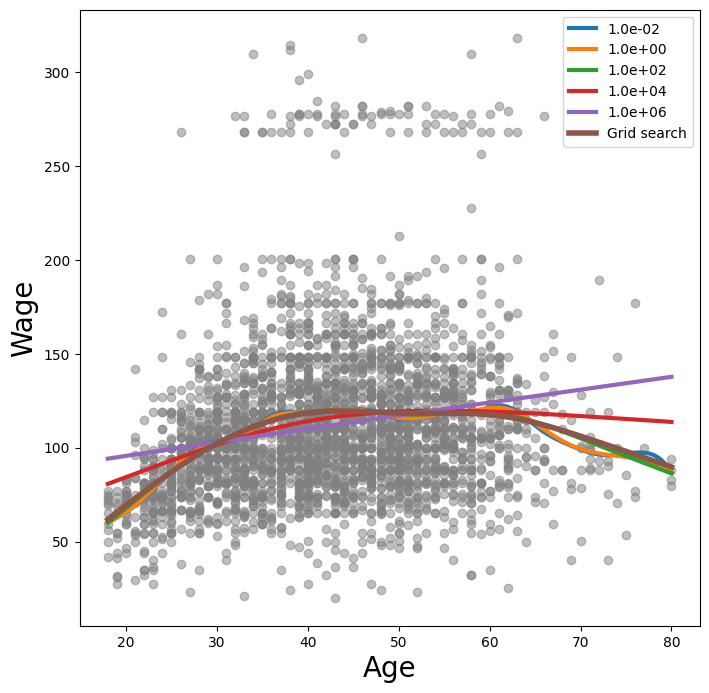

In [25]:
gam_opt = gam.gridsearch(X_age, y)
ax.plot(age_grid, gam_opt.predict(age_grid), label='Grid search', linewidth=4)
ax.legend()
fig

Alternatively, we can fix the degrees of freedom of the smoothing spline
 using a function included in the ISLP.pygam package. Below we find a value
 of that gives us roughly four degrees of freedom. We note here that these
 degrees of freedom include the unpenalized intercept and linear term of the
 smoothing spline, hence there are at least two degrees of freedom.

In [26]:
age_term = gam.terms[0]
lam_4 = approx_lam(X_age, age_term, 4)
age_term.lam = lam_4
degrees_of_freedom(X_age, age_term)

4.000000100000289

Let’s vary the degrees of freedom in a similar plot to above. We choose the
 degrees of freedom as the desired degrees of freedom plus one to account
 for the fact that these smoothing splines always have an intercept term.
 Hence, a value of one for `df` is just a linear fit.

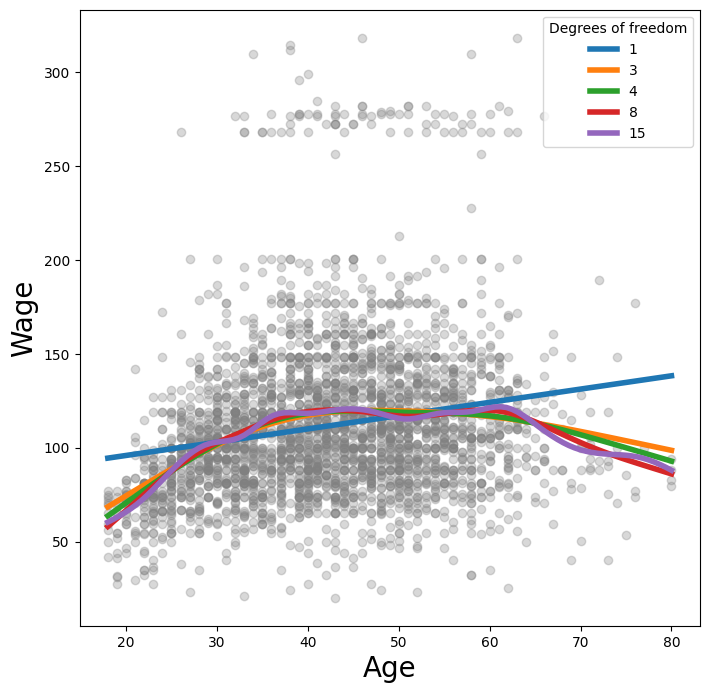

In [27]:
fig, ax = subplots(figsize=(8,8))
ax.scatter( X_age,
            y,
            facecolor='gray',
            alpha=0.3)
for df in [1,3,4,8,15]:
    lam = approx_lam(X_age, age_term, df+1)
    age_term.lam = lam
    gam.fit(X_age, y)
    ax.plot(age_grid,
            gam.predict(age_grid),
            label='{:d}'.format(df),
            linewidth=4)
ax.set_xlabel('Age', fontsize=20)
ax.set_ylabel('Wage', fontsize=20)
ax.legend(title='Degrees of freedom')

##### Additive Models with Several Terms

The strength of generalized additive models lies in their ability to fit mul
tivariate regression models with more flexibility than linear models. We
 demonstrate two approaches: 
 - the first in a more manual fashion using natural splines and piecewise constant functions, and 
 - the second using the pygam package and smoothing splines.

 We will build the model matrix in a more manual fashion here, since we
 wish to access the pieces separately when constructing partial dependence
 plots.

In [28]:
ns_age = NaturalSpline(df=4).fit(age)
ns_year = NaturalSpline(df=5).fit(Wage['year'])
Xs = [  ns_age.transform(age),
        ns_year.transform(Wage['year']),
        pd.get_dummies(Wage['education']).values]
X_bh = np.hstack(Xs)
gam_bh = sm.OLS(y, X_bh).fit()

Here, the function `NaturalSpline()` is the core function that supports the `ns()` helper function. We chose to use all columns of the indicator matrix for the categorical variable `education`, which makes the intercept redundant. Finally, we stacked the three component matrices horizontally to form the model matrix `X_bh`.

Next, we demonstrate how to construct partial dependence plots for each term in our basic Generalized Additive Model (GAM). This can be done manually by defining grids for the variables `age` and `year`. We predict with new `X` matrices, fixing all but one of the features at a time, allowing us to visualize the effect of each feature on the response.

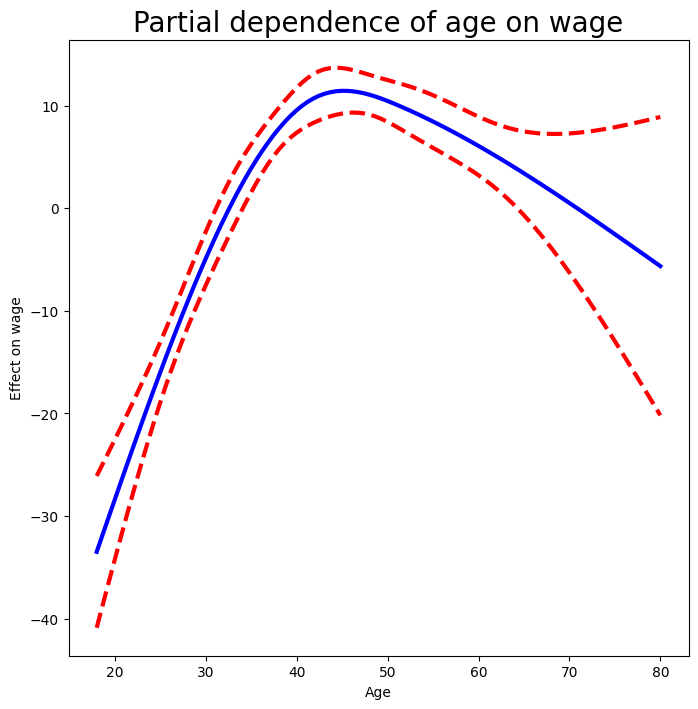

In [29]:
age_grid = np.linspace(age.min(), age.max(), 100)
X_age_bh = X_bh.copy()[:100]
X_age_bh[:] = X_bh[:].mean(0)[None,:]
X_age_bh[:,:4] = ns_age.transform(age_grid)
preds = gam_bh.get_prediction(X_age_bh)
bounds_age = preds.conf_int(alpha=0.05)
partial_age = preds.predicted_mean

# Center the predictions
center = partial_age.mean()
partial_age-= center
bounds_age-= center

fig, ax = subplots(figsize=(8,8))
ax.plot(age_grid, partial_age, 'b', linewidth=3)
ax.plot(age_grid, bounds_age[:,0], 'r--', linewidth=3)
ax.plot(age_grid, bounds_age[:,1], 'r--', linewidth=3)
ax.set_xlabel('Age')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of age on wage', fontsize=20);


The idea is to create a new prediction matrix where all columns, except for those corresponding to `age`, are constant (set to their training data means). The four columns representing `age` are populated with the natural spline basis evaluated at the 100 values in `age_grid`.

1. We created a grid of 100 values for age and constructed a matrix `X_age_bh` with 100 rows, matching the number of columns in `X_bh`.
2. Every row of this matrix is replaced with the column means of the original matrix.
3. We then replace only the first four columns (representing `age`) with the natural spline basis evaluated at the values in `age_grid`.

The remaining steps should now be familiar. We also examine the effect of `year` on `wage`, and the process is the same.

Text(0.5, 1.0, 'Partial dependence of year on wage')

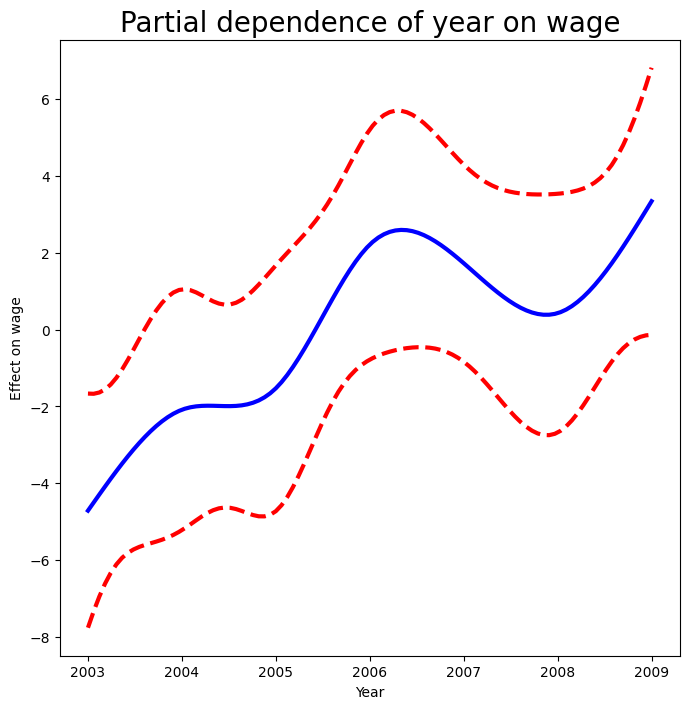

In [30]:
year_grid = np.linspace(2003, 2009, 100)
year_grid = np.linspace(Wage['year'].min(), Wage['year'].max(), 100)
X_year_bh = X_bh.copy()[:100]
X_year_bh[:] = X_bh[:].mean(0)[None,:]
X_year_bh[:,4:9] = ns_year.transform(year_grid)
preds = gam_bh.get_prediction(X_year_bh)
bounds_year = preds.conf_int(alpha=0.05)
partial_year = preds.predicted_mean
center = partial_year.mean()
partial_year-= center
bounds_year-= center
fig, ax = subplots(figsize=(8,8))
ax.plot(year_grid, partial_year, 'b', linewidth=3)
ax.plot(year_grid, bounds_year[:,0], 'r--', linewidth=3)
ax.plot(year_grid, bounds_year[:,1], 'r--', linewidth=3)
ax.set_xlabel('Year')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of year on wage', fontsize=20)

We now fit the model using smoothing splines rather than natural splines. All the terms are fit simultaneously, with each term taking the others into account to explain the response. The `pygam` package works only with matrices, so we must convert the categorical variable `education` to its array representation, which can be found using the `cat.codes` attribute of `education`. Since `year` has only 7 unique values, we use seven basis functions for it.

In [31]:
gam_full = LinearGAM(s_gam(0) + s_gam(1, n_splines=7) + f_gam(2, lam=0))
Xgam = np.column_stack([age,
Wage['year'],
Wage['education'].cat.codes])
gam_full = gam_full.fit(Xgam, y)

The two `s_gam()` terms result in smoothing spline fits, using a default value for `lam=0.6`, which is somewhat arbitrary. For the categorical term `education`, specified using the `f_gam()` term, we set `lam=0` to avoid any shrinkage. We then produce the partial dependence plot for `age` to observe the effect of these choices.

Text(0.5, 1.0, 'Partial dependence of age on wage- default lam=0.6')

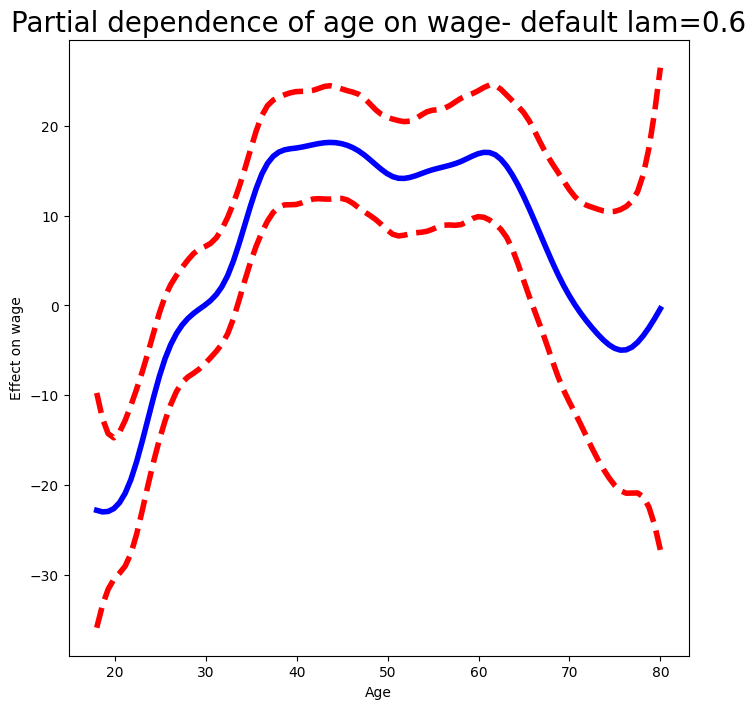

In [32]:
fig, ax = subplots(figsize=(8,8))
plot_gam(gam_full, 0, ax=ax)
ax.set_xlabel('Age')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of age on wage- default lam=0.6', fontsize=20)

We observe that the function is somewhat wiggly. It is more natural to specify the degrees of freedom (df) rather than a value for `lam`. We refit a GAM using `four` degrees of freedom for both `age` and `year`. Recall that the addition of one degree of freedom below accounts for the intercept of the smoothing spline.

In [33]:
age_term = gam_full.terms[0]
age_term.lam = approx_lam(Xgam, age_term, df=4+1)
year_term = gam_full.terms[1]
year_term.lam = approx_lam(Xgam, year_term, df=4+1)
gam_full = gam_full.fit(Xgam, y)

Repeating theplot for age, we see that it is much smoother. We also produce the plot for year.

Text(0.5, 1.0, 'Partial dependence of year on wage')

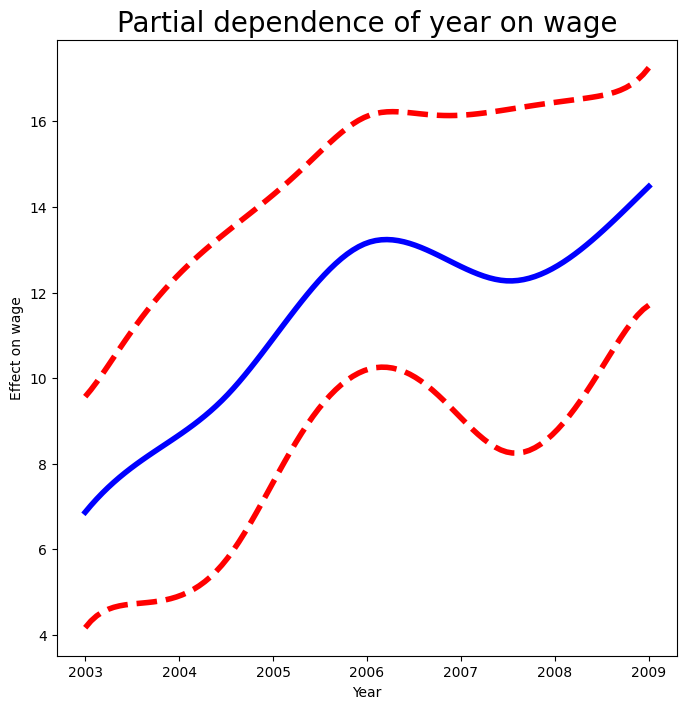

In [34]:
fig, ax = subplots(figsize=(8,8))
plot_gam(gam_full, 1, ax=ax)
ax.set_xlabel('Year')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of year on wage', fontsize=20)

Finally, we plot `education`, which is categorical. The partial dependence plot for categorical variables is different and more suitable for representing the fitted constants for each level of this variable.

[Text(0, 0, '1. < HS Grad'),
 Text(1, 0, '2. HS Grad'),
 Text(2, 0, '3. Some College'),
 Text(3, 0, '4. College Grad'),
 Text(4, 0, '5. Advanced Degree')]

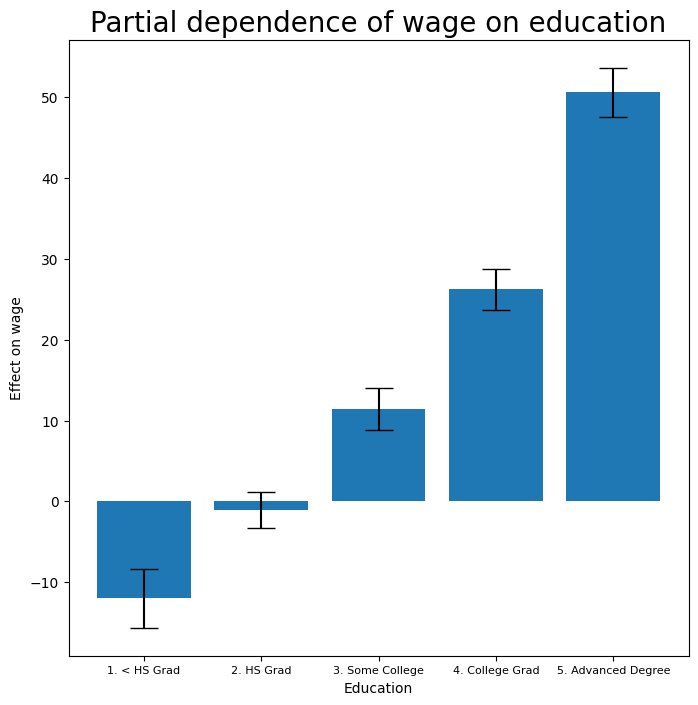

In [35]:
fig, ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_full, 2)
ax.set_xlabel('Education')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of wage on education', fontsize=20);
ax.set_xticklabels(Wage['education'].cat.categories, fontsize=8)

##### ANOVA Tests for Additive Models

In all of our models, the function of year appears to be linear. To determine the best model, we can perform a series of ANOVA tests comparing three models: a GAM that excludes year ($M_1$), a GAM that uses a linear function of year ($M_2$), and a GAM that uses a spline function of year ($M_3$).

In [36]:
gam_0 = LinearGAM(age_term + f_gam(2, lam=0))
gam_0.fit(Xgam, y)
gam_linear = LinearGAM(age_term + l_gam(1, lam=0) + f_gam(2, lam=0))
gam_linear.fit(Xgam, y)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + l(1) + f(2) + intercept, 
   tol=0.0001, verbose=False)

Notice our use of age_term in the expressions above. We do this because
 earlier we set the value for lam in this term to achieve four degrees of
 freedom.
 To directly assess the effect of year we run an ANOVA on the three
 models fit above.

In [37]:
anova_gam(gam_0, gam_linear, gam_full)

,deviance,df,deviance_diff,df_diff,F,pvalue
0,3.714362e+06,2991.004005,NaN,NaN,NaN,NaN
1,3.696746e+06,2990.005190,17616.542840,0.998815,14.265131,0.002314
2,3.693143e+06,2987.007254,3602.893655,2.997936,0.972007,0.435579


We findthatthere is compelling evidence that a GAM with a linear function
 in year is better than a GAM that does not include year at all (p-value=
 0.002). However, there is no evidence that a non-linear function of year
 is needed (p-value=0.435). In other words, based on the results of this
 ANOVA, $M_2$ is preferred.

In [38]:
gam_0 = LinearGAM(year_term + f_gam(2, lam=0))
gam_linear = LinearGAM(l_gam(0, lam=0) + year_term + f_gam(2, lam=0))
gam_0.fit(Xgam, y)
gam_linear.fit(Xgam, y)
anova_gam(gam_0, gam_linear, gam_full)

,deviance,df,deviance_diff,df_diff,F,pvalue
0,3.975443e+06,2991.000589,NaN,NaN,NaN,NaN
1,3.850247e+06,2990.000704,125196.137317,0.999884,101.270106,1.681120e-07
2,3.693143e+06,2987.007254,157103.978302,2.993450,42.447812,5.669414e-07


In [39]:
gam_full.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     12.9927
Link Function:                     IdentityLink Log Likelihood:                                 -24117.907
Number of Samples:                         3000 AIC:                                            48263.7995
                                                AICc:                                             48263.94
                                                GCV:                                             1246.1129
                                                Scale:                                           1236.4024
                                                Pseudo R-Squared:                                   0.2928
Feature Function                  Lam

C:\Users\miko_\AppData\Local\Temp\ipykernel_16760\3870570873.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_full.summary()


We can make predictions from `gam` objects, just like from `lm` objects, using the `predict()` method for the class `gam`. Here we make predictions on the training set.  In order to fit a logistic regression GAM, we use `LogisticGAM()`

In [40]:
Yhat = gam_full.predict(Xgam)

In [41]:
gam_logit = LogisticGAM(age_term + l_gam(1, lam=0) + f_gam(2, lam=0))
gam_logit.fit(Xgam, high_earn)

LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(0) + l(1) + f(2) + intercept, tol=0.0001, verbose=False)

[Text(0, 0, '1. < HS Grad'),
 Text(1, 0, '2. HS Grad'),
 Text(2, 0, '3. Some College'),
 Text(3, 0, '4. College Grad'),
 Text(4, 0, '5. Advanced Degree')]

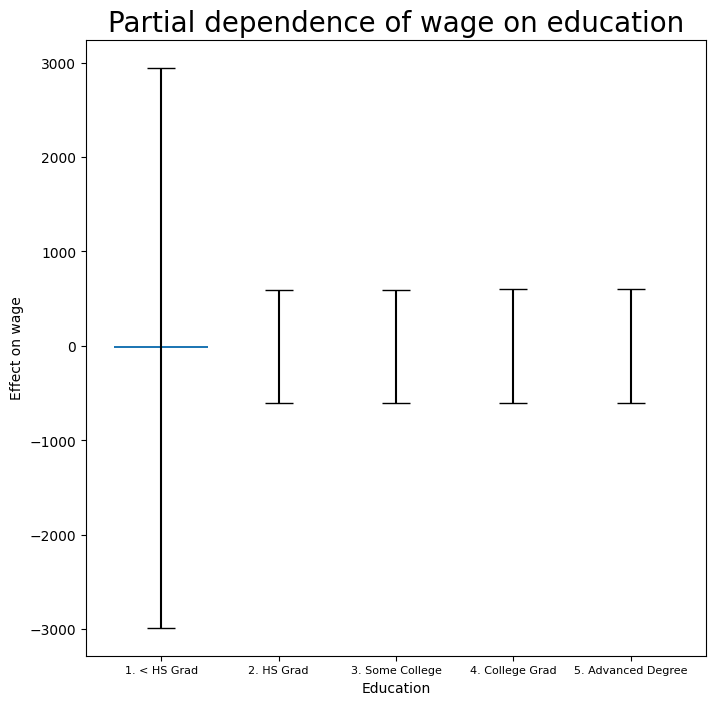

In [42]:
fig, ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_logit, 2)
ax.set_xlabel('Education')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of wage on education', fontsize=20)
ax.set_xticklabels(Wage['education'].cat.categories, fontsize=8)

The model seems to be very flat, with especially high error bars for the first category. Let’s look at the data a bit more closely.

In [43]:
pd.crosstab(Wage['high_earn'], Wage['education'])

education,1. < HS Grad,2. HS Grad,3. Some College,4. College Grad,5. Advanced Degree
high_earn,,,,,
False,268,966,643,663,381
True,0,5,7,22,45


We see that there are no high earners in the first category of education,
 meaning that the model will have a hard time fitting. We will fit a logistic
 regression GAM excluding all observations falling into this category. This
 provides more sensible results.
 To do so, we could subset the model matrix, though this will not remove
 the column from Xgam. While we can deduce which column corresponds to
 this feature, for reproducibility’s sake we reform the model matrix on this
 smaller subset. Let's examine the effect of `education`, `year`, and `age` on high earner status now that we have removed those observations.

In [44]:
only_hs = Wage['education'] == '1. < HS Grad'
Wage_ = Wage.loc[ only_hs]
Xgam_ = np.column_stack([Wage_['age'], Wage_['year'], Wage_['education'].cat.codes-1])
high_earn_ = Wage_['high_earn']

In [55]:
# Fit the model
gam_logit_ = LogisticGAM(age_term + year_term + f_gam(2, lam=0))
gam_logit_.fit(Xgam_, high_earn_)

c:\Users\miko_\AppData\Local\Programs\Python\Python312\Lib\site-packages\pygam\pygam.py:1150: RuntimeWarning: divide by zero encountered in scalar divide
  r2['explained_deviance'] = 1.0 - full_d.sum() / null_d.sum()
c:\Users\miko_\AppData\Local\Programs\Python\Python312\Lib\site-packages\pygam\pygam.py:1151: RuntimeWarning: divide by zero encountered in scalar divide
  r2['McFadden'] = full_ll / null_ll
c:\Users\miko_\AppData\Local\Programs\Python\Python312\Lib\site-packages\pygam\pygam.py:1152: RuntimeWarning: divide by zero encountered in scalar divide
  r2['McFadden_adj'] = 1.0 - (full_ll - self.statistics_['edof']) / null_ll


LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(0) + s(1) + f(2) + intercept, tol=0.0001, verbose=False)

#### Local Regression

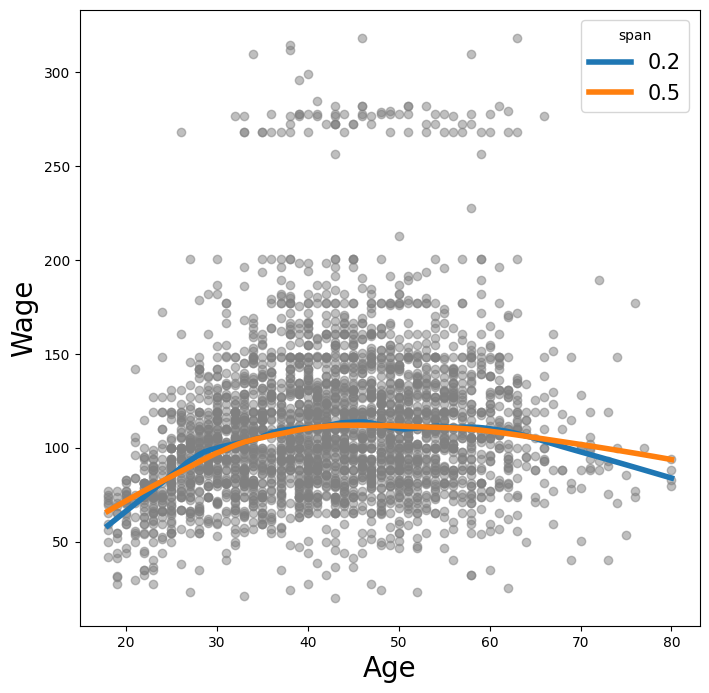

In [57]:
lowess = sm.nonparametric.lowess
fig, ax = subplots(figsize=(8,8))
ax.scatter(age, y, facecolor='gray', alpha=0.5)
for span in [0.2, 0.5]:
    fitted = lowess(y, age, frac=span, xvals=age_grid)
    ax.plot(age_grid, fitted, label='{:.1f}'.format(span), linewidth=4)
ax.set_xlabel('Age', fontsize=20)
ax.set_ylabel('Wage', fontsize=20);
ax.legend(title='span', fontsize=15)
